In [ ]:
%pip install mcp "mcp[cli]" litellm --quiet --upgrade

In [ ]:
from IPython import get_ipython
get_ipython().kernel.do_shutdown(True)

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# What is Model Context Protocol (MCP)

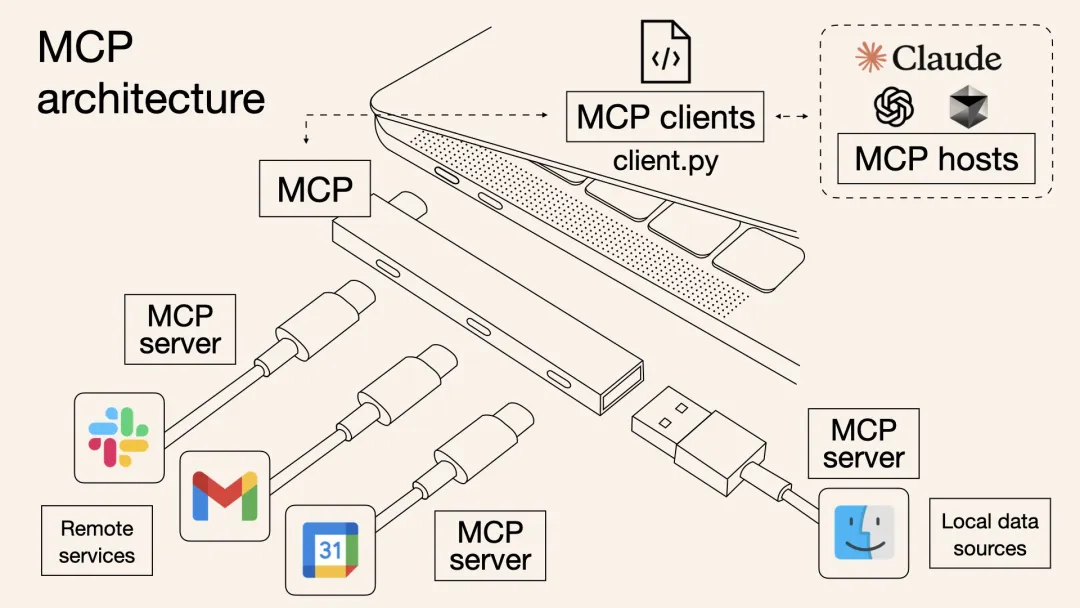

The **Model Context Protocol (MCP)** is an open standard designed to create secure, bidirectional connections between AI systems and external data sources, tools, or services. Developed initially by Anthropic and later adopted by companies like OpenAI, Block, and Apollo, MCP standardizes how AI models access and interact with real-world data, enabling more context-aware and functional AI applications.

MCP operates through a **client-server architecture**:  
- **MCP Servers**: Lightweight programs that expose specific data sources or tools (e.g., Slack, GitHub, Google Drive) through standardized interfaces.  
- **MCP Clients**: AI applications (e.g., Claude, ChatGPT) that connect to servers to retrieve data or trigger actions.  
- **JSON-RPC Communication**: Servers and clients exchange structured requests/responses in JSON format, enabling tasks like querying documents, updating databases, or executing code.

Key Benefits of using MCP include: 

- **Standardization**: Replaces fragmented, custom integrations with a universal protocol, akin to "USB-C for AI applications".  
- **Security**: Maintains data boundaries by allowing organizations to host servers locally or in secure environments.  
- **Ecosystem Growth**: Over 1,000 open-source connectors (e.g., Postgres, Puppeteer) enable rapid integration with enterprise systems.  
- **Agentic Workflows**: Supports AI agents that maintain context across tools, such as coding assistants that reference GitHub repositories and Slack messages simultaneously.

## Communication between Client and Server

Using transports like standard input/output (stdio), HTTP Server-Sent Events (SSE), or streamable HTTP under the unifying JSON-RPC 2.0 standard, MCP delivers key advantages such as superior fault isolation, dynamic service discovery, consistent security controls, and plug-and-play scalability, making it exceptionally well-suited for AI applications that require reliable, modular access to multiple resources.

The steps you will need to take to adopt MCP with your agentic workflows:

1. Build MCP Server (e.g., the `server.py` file in this repo)
2. Decide on the communication protocol (`stdio`, `sse` or streamable HTTP (not yet available in Python SDK)
3. Build the MCP Client (using your OSS framework of choice)
4. Connect and interact

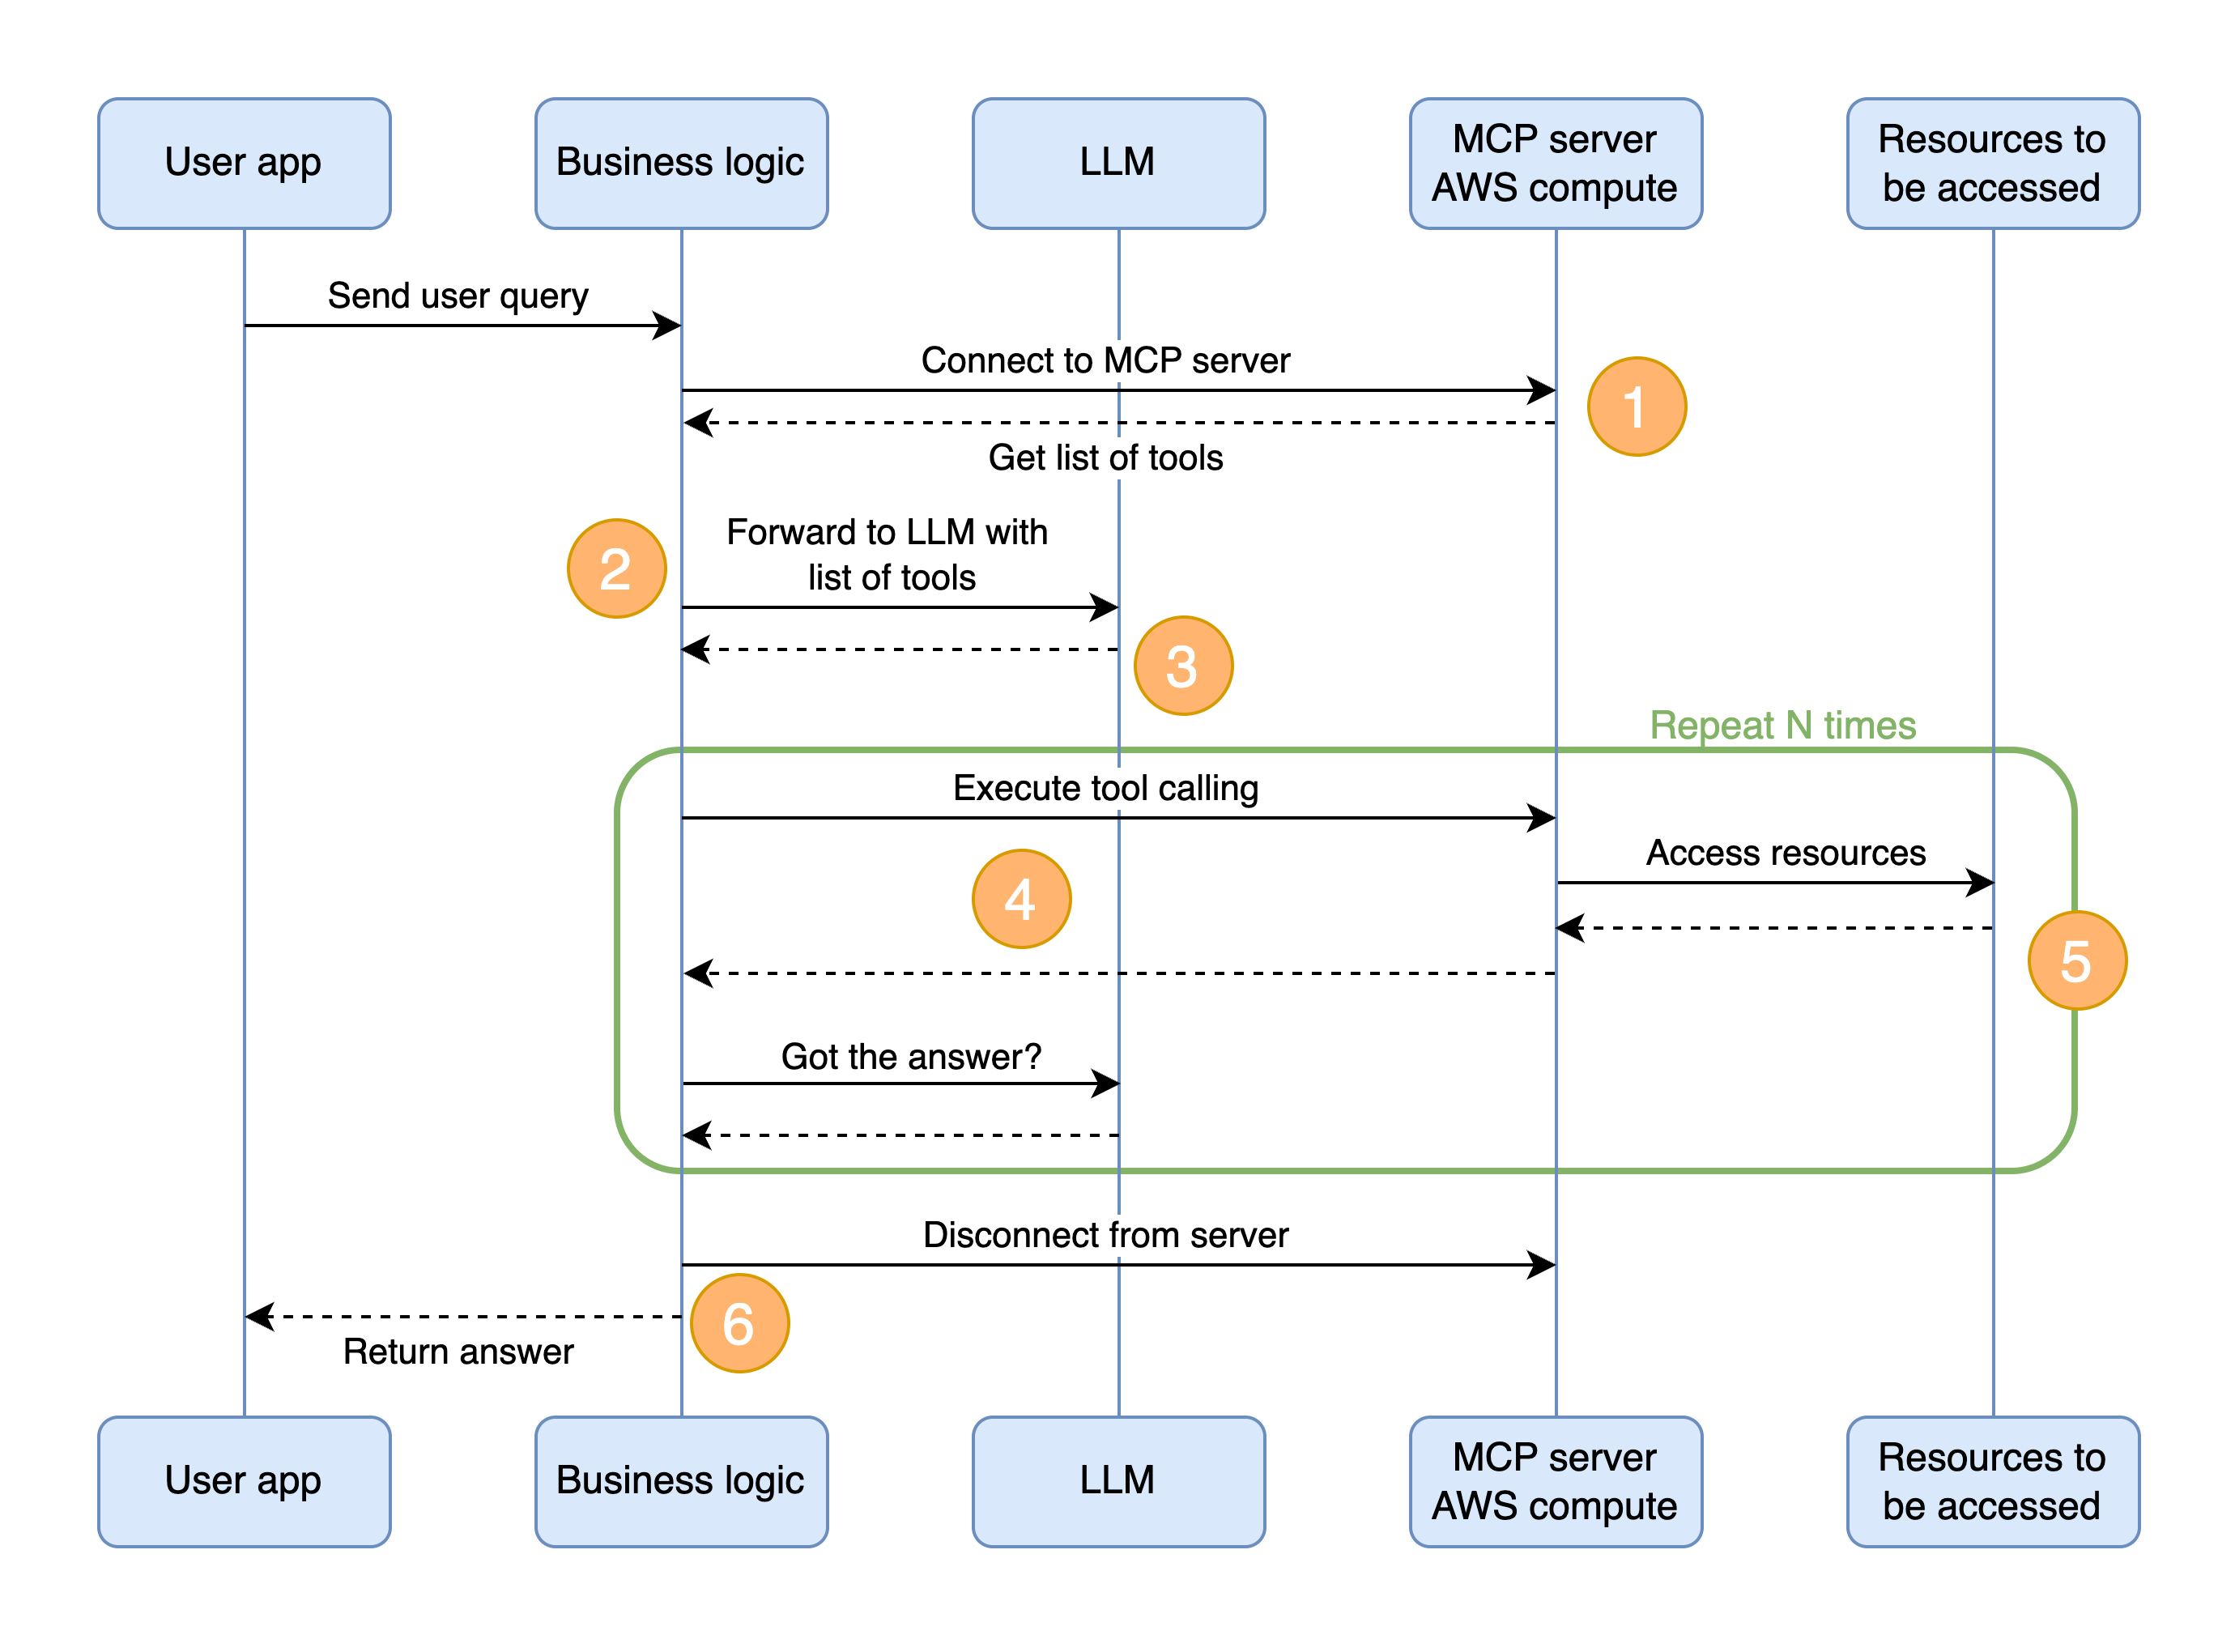

## Running the MCP Client/Server using `stdio`

In this notebook, we'll keep things simple and run the server alongside the client, and have them communicate through `stdio`.

In [ ]:
!pygmentize server.py

In the server, you can see that the chosen transport protocol is `stdio`. Also, we've decided to use FastMCP.

FastMCP is used for rapid prototyping, educational demos, and scenarios where development speed is a priority. It’s a lightweight, opinionated wrapper built specifically for quickly standing up MCP-compliant endpoints. It abstracts away much of the boilerplate—such as input/output schemas and request handling—so you can focus entirely on your model logic.

In [ ]:
from mcp import ClientSession, StdioServerParameters, types
from mcp.client.stdio import stdio_client

# Create server parameters for stdio connection
server_params = StdioServerParameters(
    command="python",  # Executable
    args=["server.py"],  # Optional command line arguments
    env=None,  # Optional environment variables
)

In [ ]:
async with stdio_client(server_params) as (read, write):
    async with ClientSession(
        read, write, 
        # sampling_callback=handle_sampling_message
    ) as session:
        # Initialize the connection
        await session.initialize()

        # List available prompts
        prompts = await session.list_prompts()
        print(prompts)

        # Get a prompt
        # prompt = await session.get_prompt(
        #     "example-prompt", arguments={"arg1": "value"}
        # )

        # List available resources
        resources = await session.list_resources()
        print(resources)

        # List available tools
        tools = await session.list_tools()
        print(tools.tools)

### Using the tools with Bedrock and LiteLLM (`completion`)

In [ ]:
from mcp.types import Tool
def mcp_tools_to_litellm_tools(tools: list[Tool])->list:
    """Convert tools to LiteLLM format"""
    litellm_tools = []
    for tool in tools:
        print(tool)
        litellm_tools.append(
            {
                "type": "function",
                "function": {
                    "name": tool.name,
                    "description": tool.description,
                    "parameters": tool.inputSchema,
                },
            }
        )
    return litellm_tools

litellm_tools = mcp_tools_to_litellm_tools(tools.tools)

In [ ]:
import litellm


messages = [{
    "role": "user",
    "content": "Tell me a joke"
}]

response = litellm.completion(
    model="bedrock/us.amazon.nova-pro-v1:0", # Uncomment to use Amazon Bedrock
    messages=messages,
    max_tokens=4096,
    temperature=0.1,
    tools=litellm_tools
)
print(response)

Note that LiteLLM `completion` API does not iterate until an answer is achieved. You will need to build the loop on your own.

### Using the tools with Bedrock and LiteLLM (`experimental_mcp_client`)

In [ ]:
from litellm import experimental_mcp_client
import litellm
import json

async with stdio_client(server_params) as (read, write):
    async with ClientSession(read, write) as session:
        # Initialize the connection
        await session.initialize()

        # Get tools
        tools = await experimental_mcp_client.load_mcp_tools(session=session, format="openai")
        # print("MCP TOOLS: ", tools)

        messages = [{
            "role": "user",
            "content": "Tell me a joke"
        }]
        llm_response = await litellm.acompletion(
            model="bedrock/us.amazon.nova-pro-v1:0", # Uncomment to use Amazon Bedrock
            messages=messages,
            max_tokens=4096,
            temperature=0.1,
            tools=tools,
        )
        print("LLM RESPONSE: ", llm_response)

As a complete loop:

In [ ]:
async with stdio_client(server_params) as (read, write):
    async with ClientSession(read, write) as session:
        # Initialize the connection
        await session.initialize()

        # Get tools
        tools = await experimental_mcp_client.load_mcp_tools(session=session, format="openai")
        # print("MCP TOOLS: ", tools)

        messages = [{
            "role": "user",
            "content": "Tell me a joke"
        }]
        llm_response = await litellm.acompletion(
            model="bedrock/us.amazon.nova-pro-v1:0", # Uncomment to use Amazon Bedrock
            messages=messages,
            max_tokens=4096,
            temperature=0.1,
            tools=tools,
        )
        # print("LLM RESPONSE: ", json.dumps(llm_response, indent=4, default=str))
        messages.append(llm_response["choices"][0]["message"])
        
        if response.choices[0].message.tool_calls:
            tool_calls = llm_response.choices[0].message.tool_calls
            for tool_call in tool_calls:
                function_name = tool_call.function.name
                function_args = json.loads(tool_call.function.arguments)
                function_id = tool_call.id
                function_output = await session.call_tool(
                    name=function_name, arguments=function_args
                )
        # print("RESULT: ", function_output)
        messages.append(
            {
                "role": "tool",
                "content": json.dumps(function_output.content[0].text),
                "tool_call_id": function_id,
            }
        )

        llm_response = await litellm.acompletion(
            model="bedrock/us.amazon.nova-pro-v1:0", # Uncomment to use Amazon Bedrock
            messages=messages,
            max_tokens=4096,
            temperature=0.1,
            tools=tools,
        )
print(f"LLM Response: {llm_response.choices[0].message.content}")
        

### Using the tools with SageMaker AI

> ⚠️ **Note for LiteLLM 1.65.7**: Currently `sagemaker_chat` does not support SageMaker Inference Component. Ref: [GitHub Issue](https://github.com/BerriAI/litellm/issues/9909).

In [ ]:
endpoint_name = "hf-llm-mistral-small-24b-instruct-2501-2025-04-07-10-48-04-846"
# inference_component_name = "hf-llm-mistral-small-24b-instruct-2501-2025-04--1744023037-a1d1"

# response = litellm.completion(
#     model=f"sagemaker_chat/{endpoint_name}",
#     # model_id=inference_component_name,
#     messages=[{ "content": "What is the weather like in Bari, Italy?","role": "user"}],
#     temperature=0,
#     max_tokens=1024,
#     tools=litellm_tools,
#     allowed_openai_params=['tools']
# )

### Using LangChain/LangGraph

In [ ]:
%pip install langchain-mcp-adapters langchain-aws langgraph --quiet --upgrade

In [ ]:
from langchain_mcp_adapters.tools import load_mcp_tools
from langgraph.prebuilt import create_react_agent
from langchain_aws import ChatBedrock

model = ChatBedrock(
    model="us.amazon.nova-pro-v1:0",
    temperature=0.7,
    region="us-west-2"
)

async with stdio_client(server_params) as (read, write):
    async with ClientSession(read, write) as session:
        # Initialize the connection
        await session.initialize()

        # Get tools
        tools = await load_mcp_tools(session)

        # Create and run the agent
        agent = create_react_agent(model, tools)
        agent_response = await agent.ainvoke({"messages": "Tell me a joke"})
print(agent_response)

In [ ]:
print(agent_response['messages'][-1].content)

## Deployment considerations

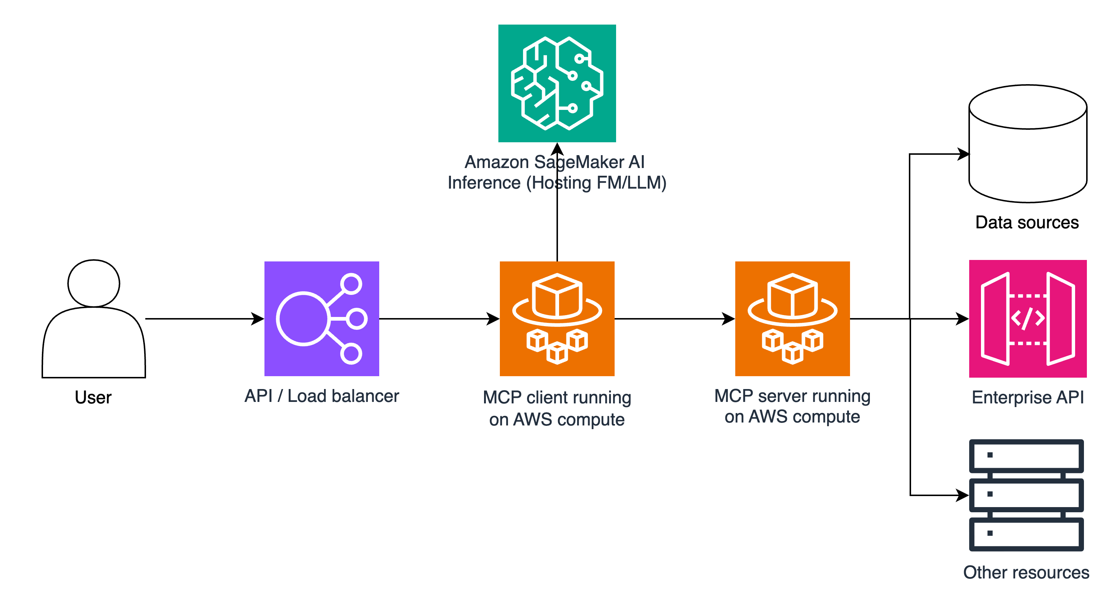

The architecture decouples the client from the server by using HTTP as the transport layer. By doing this, clients and servers can scale independently, making it a great fit for serverless orchestration powered by Lambda, AWS Fargate for Amazon ECS, or Fargate for Amazon EKS. An additional benefit of decoupling is that you can better control authorization of applications and user by controlling AWS Identity and Access Management (IAM) permissions of client and servers separately, and propagating user access to the backend. If you’re running client and server with a monolithic architecture on the same compute, we suggest instead using stdio as the transport layer to reduce networking overhead.

If you want to learn more about how to deploy MCP Servers on AWS, refer to these two GitHub repositories:

- [Run Model Context Protocol (MCP) servers with AWS Lambda](https://github.com/awslabs/run-model-context-protocol-servers-with-aws-lambda/)
- [Deploy MCP Servers on AWS using AWS Fargate](https://github.com/dgallitelli/mcp-server-with-fargate)